In [2]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from pymongo import MongoClient
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from glob import glob

### The goal is to figure out if time series model such as ARIMA or AutoReg will be better predictive models of Air Quality (PM2.5) in Lagos/Nigeria than a regular Linear or Ridge regression

Data were downloaded from https://open.africa/dataset/sensorsafrica-airquality-archive-lagos. Turns out, all the data look a bit untidy and sperated with a ";" rather than a "," among other issues.

In [19]:
data_files = glob("./data/tmp*.csv")

In [20]:
data_files[0]
pd.read_csv(data_files[0]).head(2)

,sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value
0,4852;DHT22;3627;6.515;3.400;2024-02-01T12:02:5...
1,4852;DHT22;3627;6.515;3.400;2024-02-01T12:02:5...


In [81]:
temp_df = pd.read_csv(data_files[4])
columns = temp_df.columns.str.split(";")
temp_df = temp_df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
temp_df.columns = list(columns)[0]
temp_df.tail(20)

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
90112,4854,DHT22,3628,6.559,3.386,2024-03-18T18:49:11.233004+00:00,humidity,78.10
90113,4854,DHT22,3628,6.559,3.386,2024-03-18T18:49:11.233004+00:00,temperature,32.80
90114,4853,pms5003,3628,6.559,3.386,2024-03-18T18:50:05.071658+00:00,P2,21.40
90115,4853,pms5003,3628,6.559,3.386,2024-03-18T18:50:05.071658+00:00,P1,23.60
90116,4853,pms5003,3628,6.559,3.386,2024-03-18T18:50:05.071658+00:00,P0,15.40
90117,4854,DHT22,3628,6.559,3.386,2024-03-18T18:50:18.211645+00:00,humidity,78.60
90118,4854,DHT22,3628,6.559,3.386,2024-03-18T18:50:18.211645+00:00,temperature,32.80
90119,4853,pms5003,3628,6.559,3.386,2024-03-18T18:51:09.080683+00:00,P2,23.33
90120,4853,pms5003,3628,6.559,3.386,2024-03-18T18:51:09.080683+00:00,P1,26.00
90121,4853,pms5003,3628,6.559,3.386,2024-03-18T18:51:09.080683+00:00,P0,17.67


In [87]:
temp_df[temp_df["location"] == "3628"].min()

sensor_id                                  4853
sensor_type                               DHT22
location                                   3628
lat                                       6.559
lon                                       3.386
timestamp      2024-03-01T00:00:39.896476+00:00
value_type                                   P0
value                                     10.00
dtype: object

In [90]:
temp_df[temp_df["location"] == "3630"].min()

sensor_id                                  4857
sensor_type                               DHT22
location                                   3630
lat                                       6.540
lon                                       3.297
timestamp      2024-03-01T11:01:10.225034+00:00
value_type                                   P0
value                                      0.00
dtype: object

In [82]:
temp_df["location"].value_counts()

location
3628    73685
3630    16447
Name: count, dtype: int64

In [6]:
import pytz
temp_df["timestamp"] = pd.to_datetime(temp_df["timestamp"])
temp_df = temp_df.set_index("timestamp")
temp_df.index.tz_convert("Africa/Lagos")[:5]

DatetimeIndex(['2024-02-01 13:02:52.744148+01:00',
               '2024-02-01 13:02:52.744148+01:00',
               '2024-02-01 13:03:47.839650+01:00',
               '2024-02-01 13:03:47.839650+01:00',
               '2024-02-01 13:04:46.909811+01:00'],
              dtype='datetime64[ns, Africa/Lagos]', name='timestamp', freq=None)

In [7]:
temp_df.value_type.value_counts()

value_type
P2             4270
P1             4270
P0             4270
humidity       4144
temperature    4143
Name: count, dtype: int64

In [8]:
## Starting off with the Ridge Regression Model
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_absolute_error

In [9]:
# Dealing with data wrangling
def wrangle(data_file):
    df = pd.read_csv(data_file)
    columns = df.columns.str.split(";")
    df = df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.split(";", expand=True)
    df.columns = list(columns)[0]

    # Working with only PM2.5 value_type
    df_p2 = df["value_type"] == "P2"
    df = df[df_p2]

    # Remove irrelevant columns
    df.drop(columns=['sensor_id','sensor_type', 'location', 'value_type'], inplace=True)

    # Convert timeezone to Lagos's
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df = df.set_index("timestamp")
    df.index.tz_convert("Africa/Lagos")
    
    return df

In [22]:
data_files

['./data\\tmp29zv95aa.csv',
 './data\\tmpdhpbd64k.csv',
 './data\\tmpf7lx946x.csv',
 './data\\tmpoh50r5me.csv',
 './data\\tmpq5nzwa0h.csv']

In [29]:
wrangle(data_files[4]).head()

,lat,lon,value
timestamp,,,
2024-03-01 00:00:39.896476+00:00,6.559,3.386,29.67
2024-03-01 00:01:47.310570+00:00,6.559,3.386,27.00
2024-03-01 00:02:53.783885+00:00,6.559,3.386,31.00
2024-03-01 00:04:01.176132+00:00,6.559,3.386,32.00
2024-03-01 00:05:09.205034+00:00,6.559,3.386,26.50


In [28]:
for data in data_files:
    df = wrangle(data)
    print(df.shape)

(4270, 3)
(9393, 3)
(4304, 3)
(250, 3)
(18272, 3)


In [25]:
merge_order = [3, 1, 2, 0, 4]
data_frames = []
for i in merge_order:
    data_frames.append(wrangle(data_files[i]))

In [26]:
type(data_frames)

list

In [108]:
merged_df = pd.concat(data_frames)

In [109]:
merged_df.shape

(36489, 3)

In [110]:
merged_df.head()

,lat,lon,value
timestamp,,,
2023-11-01 16:44:52.764459+00:00,6.428,3.435,19.00
2023-11-01 17:52:08.924982+00:00,6.540,3.297,3.50
2023-11-01 17:53:13.805911+00:00,6.540,3.297,3.00
2023-11-01 18:16:42.515782+00:00,6.559,3.386,40.33
2023-11-03 07:38:39.664224+00:00,6.540,3.297,47.00


In [111]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36489 entries, 2023-11-01 16:44:52.764459+00:00 to 2024-03-18 18:53:20.437257+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lat     36489 non-null  object
 1   lon     36489 non-null  object
 2   value   36489 non-null  object
dtypes: object(3)
memory usage: 1.1+ MB


##### Converting Colums to float type. (Should have done so in the Wrangle function)

In [112]:
merged_df[["lat", "lon", "value"]] = merged_df[["lat", "lon", "value"]].astype("float")

In [113]:
merged_df.head()

,lat,lon,value
timestamp,,,
2023-11-01 16:44:52.764459+00:00,6.428,3.435,19.00
2023-11-01 17:52:08.924982+00:00,6.540,3.297,3.50
2023-11-01 17:53:13.805911+00:00,6.540,3.297,3.00
2023-11-01 18:16:42.515782+00:00,6.559,3.386,40.33
2023-11-03 07:38:39.664224+00:00,6.540,3.297,47.00


In [114]:
Deciding to resample data airquality data to 1 hour mark rather than within randon minutes.

SyntaxError: invalid syntax (1766138652.py, line 1)

In [115]:
merged_df = merged_df.resample("1H").mean()
merged_df.head()

,lat,lon,value
timestamp,,,
2023-11-01 16:00:00+00:00,6.428,3.435,19.00
2023-11-01 17:00:00+00:00,6.540,3.297,3.25
2023-11-01 18:00:00+00:00,6.559,3.386,40.33
2023-11-01 19:00:00+00:00,NaN,NaN,NaN
2023-11-01 20:00:00+00:00,NaN,NaN,NaN


In [116]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3315 entries, 2023-11-01 16:00:00+00:00 to 2024-03-18 18:00:00+00:00
Freq: H
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     1271 non-null   float64
 1   lon     1271 non-null   float64
 2   value   1271 non-null   float64
dtypes: float64(3)
memory usage: 103.6 KB


In [117]:
merged_df.isnull().sum()/len(merged_df)

lat      0.616591
lon      0.616591
value    0.616591
dtype: float64

#### It appears some periods have missing data after resampling. Since these missing values are over 50% of the data frames total number of rows

In [118]:
new_df = merged_df.dropna()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1271 entries, 2023-11-01 16:00:00+00:00 to 2024-03-18 18:00:00+00:00
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   lat     1271 non-null   float64
 1   lon     1271 non-null   float64
 2   value   1271 non-null   float64
dtypes: float64(3)
memory usage: 39.7 KB


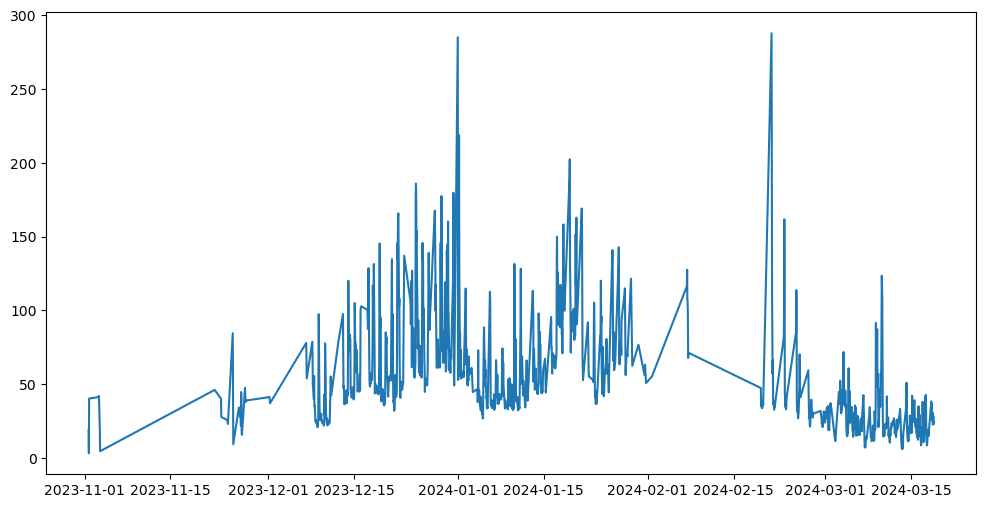

In [122]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(new_df["value"])

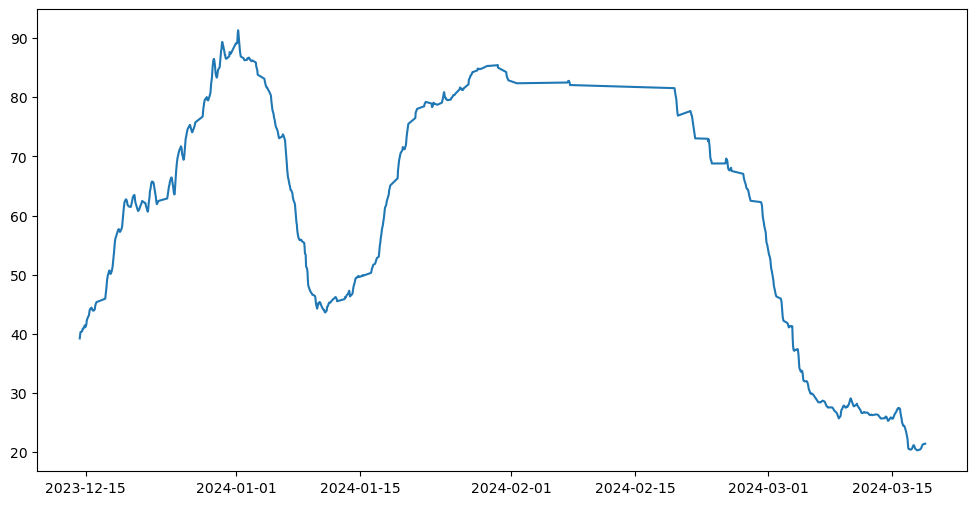

In [123]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(new_df["value"].rolling(128).mean())

In [124]:
new_df.head()

,lat,lon,value
timestamp,,,
2023-11-01 16:00:00+00:00,6.428,3.435,19.000000
2023-11-01 17:00:00+00:00,6.540,3.297,3.250000
2023-11-01 18:00:00+00:00,6.559,3.386,40.330000
2023-11-03 07:00:00+00:00,6.540,3.297,41.335000
2023-11-03 08:00:00+00:00,6.540,3.297,42.169574


In [126]:
new_df.isnull().sum()

lat      0
lon      0
value    0
dtype: int64

### Splitting the data set
##### Since this is a time based data, splitting won't be randomized
Train data set will be from Dec 2023 to Feb 2024
Test data will be march onwards

In [135]:
train = new_df[(new_df.index >= '2023-12-01 00:00:00+00:00') & (new_df.index < '2024-03-01 00:00:00+00:00')]
test = new_df[new_df.index >= '2024-03-01 00:00:00+00:00']
test.tail()

,lat,lon,value
timestamp,,,
2024-03-18 14:00:00+00:00,6.552825,3.357075,23.735875
2024-03-18 15:00:00+00:00,6.558309,3.382764,28.600545
2024-03-18 16:00:00+00:00,6.559000,3.386000,22.947593
2024-03-18 17:00:00+00:00,6.557964,3.381145,23.232000
2024-03-18 18:00:00+00:00,6.557146,3.377317,24.168293


In [136]:
features = ["lat", "lon"]
y = "value"

In [137]:
X_train, X_test = train[features], test[features]
y_train, y_test = train[y], test[y]

In [142]:
# Checking all data sets match up
len(X_train)+len(X_test) == len(train) + len(test)

True

In [149]:
from sklearn.linear_model import LinearRegression, Ridge
model = make_pipeline(
    Ridge()
)

In [150]:
model.fit(X_train, y_train)

Pipeline(steps=[('ridge', Ridge())])

In [151]:
y_pred_baseline = [y_train.mean()]*len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print(mae_baseline)

25.816903658626597


In [152]:
y_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_pred)
print(mae_train)

25.3387566446448


It appears there is no significant difference between the baseline and linear model with the train data.
This makes absolute sense since it does not look like just lat and lon alone can predict air quality.
We can try looking at how previous time air quality can predict current time air quality

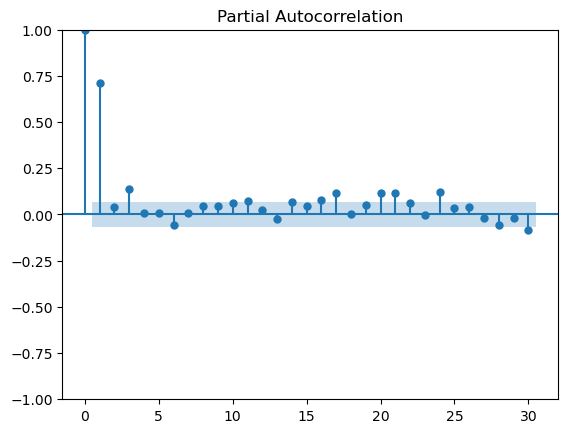

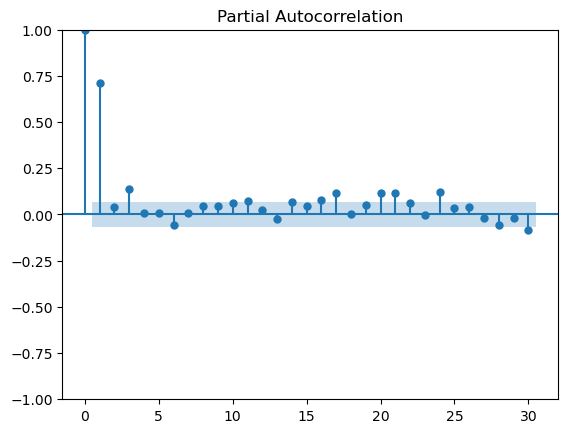

In [156]:
plot_pacf(y_train)

In [157]:
model_t = AutoReg(y_train, lags=30).fit()

C:\Users\Abdulqaadir\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [159]:
y_pred_t = model_t.predict()

In [165]:
y_pred_t.isnull().sum()

899